# [Lesson 1](https://www.youtube.com/watch?v=8SF_h3xF3cE&t=414s) - Deep Learning for Coders (Jeremy Howard)

**Idea:** primeros pasos en Deep Learning. Con pocas lineas de codigo podemos crear un modelo de computer vision que sea un clasificador de aves

**También se habla de:**
- dall-e que a partir de una descripción (en texto), con Deep Learning, genera nuevas imágenes.
- no todo es sobre imagenes! hay un modelo de lenguaje llamado Pathways (PaLM Pathways Language Model) de Google, que puede tomar cualquier texto arbitrario en inglés, una pregunta y puede crear una respuesta que no sólo responde la pregunta, sino que tabien explica su pensamiento (2022). Por ejemplo, puede explicar un chiste.. Text : input -- Model --\ Text : output
- data ethics

**Otros:**
- Metodologia cups (3 colores, 3 estados respecto a lo que estoy aprendiendo)
- [Learn Machine Learning](https://rosmulski.gumroad.com/l/learn_machine_learning) meta learning: how to learn deep learning and thrive in the digital world

**Sobre Jeremy:**
- Jeremy es el inventor del algoritmo ULMFiT que segun el libro Transformers fue uno de los dos fundamentos clave detras de la revolucion de la NLP (Natural Language Processing with Transformers, Building Language Applications with Hugging Face)
- [Howard and Ruder (2018)](https://www.researchgate.net/publication/322592284_Fine-tuned_Language_Models_for_Text_Classification) introduced Universal Language Model Fine-tuning (ULMFiT) ([PDF](https://github.com/sofiavalino/fastbook/pdfs/Fine-tuned_Language_Models_for_Text_Classification.pdf)) to facilitate transfer learning across NLP tasks.
    
    _ULMFiT includes three main procedures: (1) language model pre-training, (2) model fine-tuning (i.e., discriminative fine-tuning), and (3) classifier fine-tuning. Because the model has already captured the general properties of the language during pre-training, it is proposed that a relatively minor tweaking (i.e., fine-tuning) is sufficient for adapting the model to a specific task – e.g., text classification or generation. ULMFiT represents a strong contribution in NLP, paving the way for more advanced transfer learning models, such as those based on transformers (Wolf et al., 2019) – including GPT-2. Therefore, we consider ULMFiT as a solid baseline for our experiments._

**Vamos a usar Pytorch (mas popular que tensorflow en los ultimos años):**
- si bien es optimo por fundamentos tecnicos, requiere mucho codigo complejo para cosas relativamente simples
- base solida sobre la cual construir
- La libreria [fastai](https://docs.fast.ai) fue construida sobre pytorch, donde se reduce demasiado el codigo y mantiene la solidez (menos codigo es mejor =D). Sin embargo puede no usarse mucho... leer en [Reddit](https://www.reddit.com/r/learnmachinelearning/comments/i0d6c5/why_do_most_people_not_use_fastai_library/?rdt=45629).

**Notebook Servers**
course.fast.ai ¿como usar servidores en la nube dif para ejecutar las notebooks?
https://forums.fast.ai/t/setting-up-notebook-servers/91203


https://youtu.be/8SF_h3xF3cE?t=2176

In [ ]:
!pip install fastbook

In [3]:
from fastbook import *

In [6]:
# Buscamos en DuckDuckGo imágenes de aves (Pedimos un máximo de 1)
urls = search_images_ddg('bird photos', max_images = 1)
len(urls), urls[0]

(1,
 'https://www.birdadvisors.com/wp-content/uploads/2021/01/Eastern-Bluebirds-1-1536x1024.jpg')

In [9]:
# Descargamos la imagen
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=False)

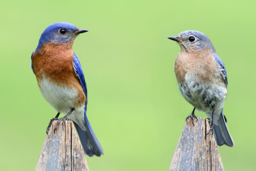

In [10]:
# Visualizamos la imagen
im = Image.open(dest)
im.to_thumb(256,256)

**Todos los modelos necesitan inputs numéricos.**

Las imagenes están hechas de números.
[PixSpy](https://es.pixspy.com/): es una página que dada una imagen, permite visualizar cada pixel con su representación numérica entre 0 y 255 (red,green,blue)


In [18]:
# Necesitamos comparar con imagenes que no sean un pajaro
# Por ejemplo, se toman imagenes de bosques
# Buscamos y descargamos 200 fotos de bosques y pajaros,
# luego se redimensionan para que no tengan mas de 400 pixeles
# No necesitamos que sea una imagen grande y lleva demasiado tiempo abrirla

from pathlib import Path

searches = 'forest','bird'
path = Path('bird_or_not')

# Crear la carpeta principal si no existe
if not path.exists():
    path.mkdir()

for o in searches:
    # Crear las subcarpetas para cada categoría (forest y bird)
    dest = path / o
    dest.mkdir(exist_ok=True)

    # Descargar las 200 imágenes
    results = search_images_ddg(f'{o} photo')
    download_images(dest, urls=results[:200])

    # Redimensionar imágenes
    resize_images(dest, max_size=400, dest=dest)

len(get_image_files(path))

377

In [20]:
# Cuando descargamos imagenes, a menudo estan rotas
# Si queremos entrenar un modelo y usamos imagenes rotas, no funcionara
# Usamos el siguiente metodo que "valida" las imagenes que están ok y las que no, las elimina

failed = verify_images(get_image_files(path))
failed.map(Path.unlink); # unlink/desvincular aquellas que no sirvan
len(get_image_files(path))

364

Ahora, creamos un "datablock" o "bloque de datos", otorgandole a la libreria de fast.ai toda la info que requiere para crear un modelo de computer vision.

Pasos:
1. Definir un DataBlock para especificar cómo procesar las imágenes y las etiquetas.

  *Un DataBlock en fast.ai es una forma de organizar y preprocesar tus datos de manera eficiente, indicándole a la librería cómo manejar los elementos del dataset (en este caso, imágenes y etiquetas).*

 `blocks=(ImageBlock, CategoryBlock)`

  *ImageBlock: le indica fast.ai que los elementos de entrada son **imágenes**. Este bloque se encarga de convertir las imágenes a un formato que se pueda usar en un modelo.*
  
  *CategoryBlock: Esto le dice a fast.ai que las etiquetas asociadas a las imágenes son categorías. Es decir, cada imagen tendrá una etiqueta (como "pájaro" o "bosque", si ese es el caso de tu dataset).*

2. Obtener las imágenes con get_image_files.
3. Dividir el conjunto de datos en entrenamiento y validación con RandomSplitter.

  `splitter=RandomSplitter(valid_pct=0.2, seed=42):`

  *RandomSplitter divide el dataset en dos conjuntos: uno para entrenamiento y otro para validación.*

  **valid_pct=0.2** significa que el 20% de las imágenes se usarán para validación y el 80% para entrenamiento.

  **seed=42** garantizara que la división sea reproducible. Si usas el mismo seed, siempre obtendrás la misma división de datos.

4. Obtener las etiquetas con parent_label, usando el nombre de las carpetas.

  **parent_label** *es una función que obtiene la etiqueta de la imagen basada en la carpeta donde está almacenada la imagen. Por ejemplo, si la imagen está en una subcarpeta llamada bird, la etiqueta de esa imagen será "bird".*

5. Aplicar transformaciones como redimensionar las imágenes antes de usarlas en el modelo.
  
  **Resize(192, method='squish')**: Redimensiona las imágenes a un tamaño de 192 píxeles. La opción method='squish' significa que las imágenes serán estiradas para ajustarse a esa dimensión, sin mantener las proporciones ( cambiar a otro método si hay que mantener la relación de aspecto).

6. Generar DataLoaders para alimentar los datos al modelo.
  
  Después de crear el DataBlock, se usa .dataloaders(path) para generar un DataLoader, que es la estructura de datos que se alimentará al modelo durante el entrenamiento con el contenido de path (imagenes)
  
7. Mostrar un lote de imágenes para asegurarte de que todo está bien configurado.

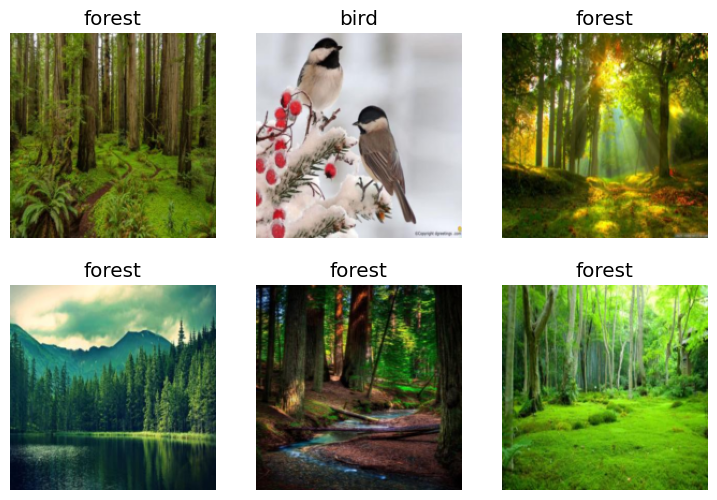

In [22]:
from fastai.data.block import DataBlock
from fastai.vision.all import *

dls = DataBlock( # Crear el DataBlock para indicar cómo debe procesar los datos el modelo
    blocks=(ImageBlock, CategoryBlock), # entrada al modelo: imagenes por categoria pajaro/bosque
    get_items=get_image_files,  # dame todas las imagenes que recolectamos
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% test y 80% train
    get_y=parent_label, # obtener etiquetas con el nombre de la carpeta, las img estan separados en directorios /pajaro y /bosque
    item_tfms=[Resize(192, method='squish')] # Redimensionar con el metodo squish
).dataloaders(path) # Generar el DataLoader para alimentar al modelo con las imagenes

dls.show_batch(max_n = 6) #mostrar 6

Algo muy interesante de los modelos de computer vision es que es muy facil verificar los datos porque pueden simplemente "mirarlos" (vision, je) lo que no es el caso de otros modelos


**Ahora vamos a usar la librería fast.ai para entrenar un modelo de red neuronal convolucional (CNN) para clasificación de imágenes.**

`cnn_learner(dls, resnet18, metrics=error_rate)`: Crea un modelo de red neuronal convolucional utilizando la arquitectura preentrenada ResNet-18 y ajustada a tu conjunto de datos de imágenes.

- cnn_learner: función que configura una red neuronal convolucional preentrenada (en este caso, resnet18) y la ajusta a las datos de imagen. Además, crea todo el ciclo de entrenamiento, validación y evaluación del modelo.

- dls: es el objeto DataLoader (creado en el paso anterior con DataBlock), que contiene el conjunto de datos dividido en lotes. Es el que le pasamos al modelo para que aprenda a partir de las imágenes y etiquetas.

- resnet18: modelo preentrenado que se utilizará para el aprendizaje. Es una arquitectura de red neuronal convolucional profunda (con 18 capas) que ya ha sido entrenada en un gran conjunto de datos (como ImageNet). El uso de un modelo preentrenado es una técnica llamada **transfer learning**, que permite que el modelo aproveche lo que ha aprendido previamente y lo ajuste a tu tarea específica.

- metrics=error_rate: define la métrica que se usará para evaluar el rendimiento del modelo durante el entrenamiento y la validación. En este caso, se está utilizando la tasa de error (es decir, el porcentaje de imágenes mal clasificadas). Se pueden usar otras métricas como por ejemplo: precisión, F1, etc.

`learn.fine_tune(3)`: Realiza un fine-tuning del modelo durante 3 épocas para adaptar las últimas capas de la red a tus datos específicos (las imágenes del conjunto de datos).

- fine_tune(3): El número 3 especifica la cantidad de épocas (epochs) durante las cuales se va a realizar el fine-tuning.
Un epoch es una iteración completa sobre todo el conjunto de entrenamiento. Entonces, si pones 3, el **modelo pasará tres veces por el conjunto de entrenamiento ajustando sus pesos en cada paso**.
- Durante el fine-tuning, **el modelo primero congela las primeras capas de la red** (que ya están preentrenadas en ImageNet y no necesitan cambiar mucho) y **luego entrena las últimas capas para que se adapten a los datos**. En algunas configuraciones, puede especificarse si se desean entrenar todas las capas o solo las últimas.


**¿Por qué usar fine_tune?**

Usar fine_tune con un modelo preentrenado, como ResNet-18, es una forma muy eficiente de entrenar modelos. La red ya ha aprendido características importantes sobre las imágenes (como bordes, texturas, formas, etc.), por lo que al usar ese conocimiento previo, el entrenamiento en un conjunto de datos de interés puede ser mucho más rápido y efectivo.

In [23]:
# Esto va a recorrer cada foto de las 400 (200 de bosques y 200 de aves)
# y para las que son de bosques, aprendera un poco mas sobre como se ve un bosque (idem parajos)

learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.776183,0.491531,0.191781,00:54


epoch,train_loss,valid_loss,error_rate,time
0,0.107477,0.018801,0.000000,01:09
1,0.064123,0.052439,0.027397,01:10
2,0.044442,0.068301,0.027397,01:03


## Probemos el clasificador



```learn.predict(PILImage.create('bird.jpg'))```


Este código utiliza el modelo entrenado (learn) para hacer una predicción sobre una imagen ('bird.jpg') y luego imprime el resultado.

Devuelve tres cosas:
* is_bird: La etiqueta predicha por el modelo (por ejemplo, "bird" o "not bird").
* _: No se usa en este caso (el segundo valor es generalmente la etiqueta real o el valor de la pérdida, pero aquí se ignora).
* probs: Un vector de probabilidades que indica qué tan seguro está el modelo sobre su predicción (por ejemplo, la probabilidad de que sea un pájaro).

**Vemos si la imagen se trata de un ave**

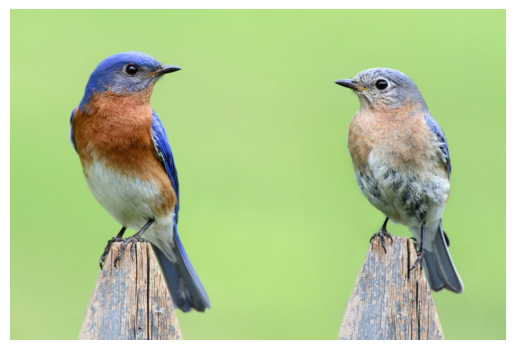

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

# Cargar y mostrar la imagen
img = Image.open('bird.jpg')
plt.imshow(img)
plt.axis('off')  # Opcional: desactiva los ejes
plt.show()

**Hacemos la predicción**

In [25]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"Thiss is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

Thiss is a: bird.
Probability it's a bird: 1.0000


## Parentesis para reflexionar

### ¿Cómo es que hacemos un clasificador de aves en 2 min y antes no se podia?

Menciona como se hacia el reconocimiento de imagenes en el 2013, hay un proyecto de stanford de reconocimiento de patologias de cancer de mama, es un enfoque clasico de machine learning. Se crearon miles y miles de features, llevo años y mucho codigo y matematica, luego de tener todas las features lo metieron en un modelo de regresion logistica.

La diferencia con las redes neuronales es que, **no necesitan** que creemos las features, sino que **las crean por nosotros**. No le damos features, sino que le pedimos que aprenda features.
Deep learning es **profundo**, porque podemos tomar las features y combinarlas, creando caracteristicas mas avanzadas. En cada CAPA se encontrara una mayor complejidad.

Con una red neuronal, que es la funcion basica utilizada en deep learning, no tenemos que codificar manualmente ninguna de las funciones ni idear ninguna de las ideas, solo comenzamos con una red neuronal aleatoria y le damos ejemplos, haciendo que aprenda a reconocerlas, creando cosas por si misma. Esto se puede hacer ahora porque no debemos codificar las features nosotros, sino que todo se puede aprender mediante redes neuronales.

### ¿Cómo construir algoritmos basados en imagenes?

No son solo para imagenes, en este curso sera un tema general. En este curso veremos tecnicas fundamentales, que con creatividad, estas tecnicas pueden utilizarse de manera muy amplia.

Algunos ejemplos de aplicacion de un clasificador de imagenes:

* A partir de sonidos crear imagenes y usar un clasificador de imagenes para clasificar los sonidos (niños gritando)
* Tomar series de tiempo, convertirlas en imagenes y clasificarlas
* Crear imagenes a partir de movimientos del cursor (clicks puntos y movimientos lineas, velocidad de movimiento se convirtio en colores)

### Transfer Learning
